In [1]:
import numpy as np
import csv

In [2]:
labels = []

with open("data/legend.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(row[1:])
labels = np.array(labels[1:])

labels

array([['facial-expressions_2868588k.jpg', 'anger'],
       ['facial-expressions_2868585k.jpg', 'surprise'],
       ['facial-expressions_2868584k.jpg', 'disgust'],
       ...,
       ['SharmilaTagore_82.jpg', 'HAPPINESS'],
       ['SharmilaTagore_83.jpg', 'HAPPINESS'],
       ['SharmilaTagore_9.jpg', 'HAPPINESS']], dtype='<U44')

In [3]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
#if true, re-reads and saves all images to numpy array
if False:
    images = []
    size = (128,128)
    print("reading in images...")
    for line in tqdm(labels):
        ##read and convert to Black and White
        img = io.imread('images/'+line[0], as_grey=True)
        img = resize(img, size)
        images.append(img)
    print("saving...")
    
    npimages = np.zeros(shape=(len(images),*size), dtype=np.float64)
    for i,im in enumerate(images):
        npimages[i] = im
    labels = np.array(labels[:,1],dtype=str)
    np.save("data/labels.npy",labels)
    np.save("data/images.npy",npimages)
    

In [5]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")
print(images.dtype)
print(labels.dtype)

float64
<U44


		anger


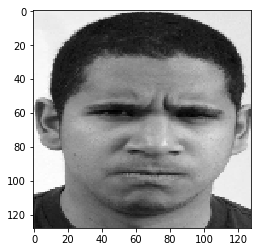

In [6]:
idx = 0
plt.imshow(images[idx], cmap="gray")
print("\t\t"+str(labels[idx]))

In [7]:
import random
def balanced_subset(images,labels):
    #np.warnings.filterwarnings('ignore')
    count = Counter(labels)
    perclass_count = np.array([[c,count[c]] for c in count.keys()])
    max_n = min(perclass_count[:,1])
    
    perclass_indexes = {cname:random.sample(range(0, n), max_n) for cname,n in perclass_count}
    perclass_index = {label:0 for label in count.keys()}
    
    newlabels = []
    newimages = []
    total = 0
    for i in range(len(labels)):
        
        label = labels[i]

        if perclass_index[label] in perclass_indexes[label]:
            total += 1
            newlabels.append(label)
            newimages.append(images[i])
        perclass_index[label] += 1
            
    newimages, newlabels = np.array(newimages),np.array(newlabels)   
        
    #print(perclass_count,perclass_indexes)
    return newimages, newlabels

In [8]:
from collections import Counter
labels = [x.lower() for x in labels]
count = Counter(labels)
#print(c.most_common())
label2int = {y:x for x,(y,_) in enumerate(count.most_common())}

nplabels = np.array([label2int[x] for x in labels])
assert(len(nplabels) == len(images))
print("count:",count.most_common(),"\n")




count: [('neutral', 6868), ('happiness', 5696), ('surprise', 368), ('sadness', 268), ('anger', 252), ('disgust', 208), ('fear', 21), ('contempt', 9)] 



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(images, nplabels, test_size=.01)
len(y_val)

137

In [10]:
def next_batch(images, labels, batch_size):
    for i in range(0,len(labels),batch_size):
        if i+batch_size >= len(labels):
            yield images[i:],labels[i:]
        else:
            yield images[i:i+batch_size],labels[i:i+batch_size]

In [11]:
print(images[0].shape)

(128, 128)


# Build Model

In [12]:
import tensorflow as tf

In [13]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float32, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.uint8, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")

In [14]:
one_hot = tf.one_hot(y,num_classes)
reshaped = tf.expand_dims(x,-1)

In [15]:
#batch,128,128,1

#first convolution
conv = tf.contrib.layers.conv2d(
    reshaped,
    32,
    (9,9),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,120,120,32

#subsample
pool = tf.contrib.layers.max_pool2d(
    conv,
    (4,4),
    stride=(4,4))
#batch,30,30,32

#second convolution
conv2 = tf.contrib.layers.conv2d(
    pool,
    64,
    (11,11),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,20,20,64

#subsample
pool2 = tf.contrib.layers.max_pool2d(
    conv2,
    (4,4),
    stride=(4,4))
#batch,5,5,64

#flatten
flat = tf.contrib.layers.flatten(pool2)
#batch,1600

#fully connected
fc = tf.contrib.layers.fully_connected(
    flat,
    1024,
    activation_fn=tf.nn.relu,
    weights_initializer=tf.initializers.random_normal)
#batch,256
logits = tf.contrib.layers.fully_connected(
    fc,
    num_classes,
    weights_initializer=tf.initializers.random_normal,
    activation_fn=None)

prediction = tf.nn.softmax(logits,)

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss_op)
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [17]:
epochs = 2000
learn_rate = .0001
batch_size = 256

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(epochs):
        batch_i = 1
        #for X,Y in next_batch(x_train,y_train,batch_size):
        X,Y = balanced_subset(images,nplabels)
        X,Y = shuffle(X,Y)
        
        for i in range(10):
            sess.run(optimizer,feed_dict={x:X,y:Y,lr:learn_rate})
            if batch_i % 10 == 0:
                valacc = sess.run(accuracy,feed_dict={x:x_val,y:y_val})
                loss, trainacc = sess.run([loss_op, accuracy], feed_dict={x:X,y:Y})
                print("epoch {} \tbatch: {}\ttrain accuracy: {}\tloss: {}\tval acc: {}"
                      .format(epoch,batch_i,round(float(trainacc),4),round(float(loss),4), round(float(valacc),4)))               
                
            batch_i += 1
    X,Y = balanced_subset(images,nplabels)
    X,Y = shuffle(X,Y)
    save_path = saver.save(sess, "checkpoints/model.ckpt")

            

epoch 0 	batch: 10	train accuracy: 0.1389	loss: 138472.0469	val acc: 0.5036
epoch 1 	batch: 10	train accuracy: 0.1111	loss: 102228.9453	val acc: 0.2263
epoch 2 	batch: 10	train accuracy: 0.1528	loss: 81783.3281	val acc: 0.0803
epoch 3 	batch: 10	train accuracy: 0.1667	loss: 69232.9766	val acc: 0.1606
epoch 4 	batch: 10	train accuracy: 0.0972	loss: 53705.332	val acc: 0.2409
epoch 5 	batch: 10	train accuracy: 0.1528	loss: 44679.9922	val acc: 0.2482
epoch 6 	batch: 10	train accuracy: 0.2083	loss: 33792.3906	val acc: 0.1679
epoch 7 	batch: 10	train accuracy: 0.125	loss: 40517.2734	val acc: 0.1679
epoch 8 	batch: 10	train accuracy: 0.125	loss: 34277.2891	val acc: 0.1752
epoch 9 	batch: 10	train accuracy: 0.125	loss: 30725.8848	val acc: 0.1533
epoch 10 	batch: 10	train accuracy: 0.1806	loss: 28997.5391	val acc: 0.1898
epoch 11 	batch: 10	train accuracy: 0.1944	loss: 31338.959	val acc: 0.2701
epoch 12 	batch: 10	train accuracy: 0.1528	loss: 29775.1738	val acc: 0.2117
epoch 13 	batch: 10	train

epoch 109 	batch: 10	train accuracy: 0.4444	loss: 7092.8491	val acc: 0.2701
epoch 110 	batch: 10	train accuracy: 0.5139	loss: 7460.9644	val acc: 0.3431
epoch 111 	batch: 10	train accuracy: 0.6111	loss: 4768.1089	val acc: 0.3285
epoch 112 	batch: 10	train accuracy: 0.4306	loss: 7456.6895	val acc: 0.3431
epoch 113 	batch: 10	train accuracy: 0.6528	loss: 4947.603	val acc: 0.3285
epoch 114 	batch: 10	train accuracy: 0.4583	loss: 7604.1997	val acc: 0.2847
epoch 115 	batch: 10	train accuracy: 0.4167	loss: 5415.29	val acc: 0.3358
epoch 116 	batch: 10	train accuracy: 0.5	loss: 8161.7231	val acc: 0.365
epoch 117 	batch: 10	train accuracy: 0.4861	loss: 6469.1885	val acc: 0.2628
epoch 118 	batch: 10	train accuracy: 0.5556	loss: 7481.6147	val acc: 0.3431
epoch 119 	batch: 10	train accuracy: 0.4722	loss: 6197.5415	val acc: 0.3066
epoch 120 	batch: 10	train accuracy: 0.5139	loss: 6480.4697	val acc: 0.3504
epoch 121 	batch: 10	train accuracy: 0.6667	loss: 3693.0457	val acc: 0.2847
epoch 122 	batch: 1

epoch 217 	batch: 10	train accuracy: 0.5972	loss: 4457.9785	val acc: 0.3577
epoch 218 	batch: 10	train accuracy: 0.625	loss: 4149.0225	val acc: 0.365
epoch 219 	batch: 10	train accuracy: 0.5972	loss: 4979.0273	val acc: 0.3869
epoch 220 	batch: 10	train accuracy: 0.625	loss: 6099.9585	val acc: 0.3358
epoch 221 	batch: 10	train accuracy: 0.4861	loss: 4198.0845	val acc: 0.3504
epoch 222 	batch: 10	train accuracy: 0.6389	loss: 3435.5854	val acc: 0.3796
epoch 223 	batch: 10	train accuracy: 0.5972	loss: 4781.0981	val acc: 0.3139
epoch 224 	batch: 10	train accuracy: 0.6528	loss: 4121.0347	val acc: 0.365
epoch 225 	batch: 10	train accuracy: 0.6111	loss: 3865.3098	val acc: 0.3577
epoch 226 	batch: 10	train accuracy: 0.6528	loss: 4321.8438	val acc: 0.3212
epoch 227 	batch: 10	train accuracy: 0.5556	loss: 4960.3267	val acc: 0.4526
epoch 228 	batch: 10	train accuracy: 0.5694	loss: 3638.8682	val acc: 0.3139
epoch 229 	batch: 10	train accuracy: 0.5833	loss: 5109.7998	val acc: 0.3577
epoch 230 	batch

epoch 325 	batch: 10	train accuracy: 0.7778	loss: 2246.1914	val acc: 0.438
epoch 326 	batch: 10	train accuracy: 0.5972	loss: 3336.9453	val acc: 0.438
epoch 327 	batch: 10	train accuracy: 0.6389	loss: 2876.6252	val acc: 0.4161
epoch 328 	batch: 10	train accuracy: 0.7083	loss: 2304.7515	val acc: 0.438
epoch 329 	batch: 10	train accuracy: 0.6528	loss: 3326.2092	val acc: 0.365
epoch 330 	batch: 10	train accuracy: 0.6667	loss: 4549.4541	val acc: 0.438
epoch 331 	batch: 10	train accuracy: 0.7222	loss: 2116.4319	val acc: 0.4161
epoch 332 	batch: 10	train accuracy: 0.7917	loss: 2525.9443	val acc: 0.4526
epoch 333 	batch: 10	train accuracy: 0.6667	loss: 3643.0496	val acc: 0.438
epoch 334 	batch: 10	train accuracy: 0.6806	loss: 2386.7769	val acc: 0.5182
epoch 335 	batch: 10	train accuracy: 0.6389	loss: 2643.042	val acc: 0.3869
epoch 336 	batch: 10	train accuracy: 0.6806	loss: 3690.5942	val acc: 0.4818
epoch 337 	batch: 10	train accuracy: 0.5833	loss: 3646.1042	val acc: 0.4599
epoch 338 	batch: 1

epoch 433 	batch: 10	train accuracy: 0.8056	loss: 1799.3522	val acc: 0.4453
epoch 434 	batch: 10	train accuracy: 0.7222	loss: 2304.3384	val acc: 0.4964
epoch 435 	batch: 10	train accuracy: 0.7222	loss: 2689.5947	val acc: 0.5109
epoch 436 	batch: 10	train accuracy: 0.6389	loss: 3575.8418	val acc: 0.4891
epoch 437 	batch: 10	train accuracy: 0.7222	loss: 1872.6417	val acc: 0.4891
epoch 438 	batch: 10	train accuracy: 0.6806	loss: 2918.1055	val acc: 0.4599
epoch 439 	batch: 10	train accuracy: 0.7222	loss: 2288.4573	val acc: 0.438
epoch 440 	batch: 10	train accuracy: 0.7778	loss: 1619.7887	val acc: 0.5036
epoch 441 	batch: 10	train accuracy: 0.7917	loss: 1898.887	val acc: 0.5036
epoch 442 	batch: 10	train accuracy: 0.75	loss: 2176.7231	val acc: 0.5109
epoch 443 	batch: 10	train accuracy: 0.8056	loss: 1554.7437	val acc: 0.4526
epoch 444 	batch: 10	train accuracy: 0.7083	loss: 2171.7395	val acc: 0.5109
epoch 445 	batch: 10	train accuracy: 0.75	loss: 2211.5447	val acc: 0.4526
epoch 446 	batch: 

epoch 541 	batch: 10	train accuracy: 0.8056	loss: 1648.4642	val acc: 0.5401
epoch 542 	batch: 10	train accuracy: 0.7222	loss: 1517.5131	val acc: 0.5182
epoch 543 	batch: 10	train accuracy: 0.8472	loss: 1151.5861	val acc: 0.5036
epoch 544 	batch: 10	train accuracy: 0.7639	loss: 1374.1948	val acc: 0.4599
epoch 545 	batch: 10	train accuracy: 0.7639	loss: 1022.6903	val acc: 0.4672
epoch 546 	batch: 10	train accuracy: 0.7917	loss: 1784.561	val acc: 0.4818
epoch 547 	batch: 10	train accuracy: 0.7778	loss: 1072.0806	val acc: 0.5328
epoch 548 	batch: 10	train accuracy: 0.7639	loss: 2353.77	val acc: 0.4672
epoch 549 	batch: 10	train accuracy: 0.6667	loss: 1202.699	val acc: 0.5328
epoch 550 	batch: 10	train accuracy: 0.75	loss: 1503.0668	val acc: 0.4818
epoch 551 	batch: 10	train accuracy: 0.75	loss: 2035.5957	val acc: 0.4964
epoch 552 	batch: 10	train accuracy: 0.8333	loss: 927.9644	val acc: 0.4745
epoch 553 	batch: 10	train accuracy: 0.7639	loss: 1475.8641	val acc: 0.5839
epoch 554 	batch: 10	

epoch 649 	batch: 10	train accuracy: 0.7778	loss: 1288.5044	val acc: 0.5109
epoch 650 	batch: 10	train accuracy: 0.875	loss: 920.8214	val acc: 0.5474
epoch 651 	batch: 10	train accuracy: 0.7917	loss: 787.9939	val acc: 0.5109
epoch 652 	batch: 10	train accuracy: 0.8056	loss: 927.0073	val acc: 0.4891
epoch 653 	batch: 10	train accuracy: 0.8194	loss: 1313.2495	val acc: 0.5328
epoch 654 	batch: 10	train accuracy: 0.8472	loss: 686.3391	val acc: 0.5328
epoch 655 	batch: 10	train accuracy: 0.8889	loss: 508.5452	val acc: 0.5109
epoch 656 	batch: 10	train accuracy: 0.7778	loss: 1537.8586	val acc: 0.562
epoch 657 	batch: 10	train accuracy: 0.8194	loss: 1727.1721	val acc: 0.5036
epoch 658 	batch: 10	train accuracy: 0.8889	loss: 952.9617	val acc: 0.5182
epoch 659 	batch: 10	train accuracy: 0.8333	loss: 1140.2628	val acc: 0.562
epoch 660 	batch: 10	train accuracy: 0.875	loss: 596.3603	val acc: 0.5328
epoch 661 	batch: 10	train accuracy: 0.8472	loss: 947.3655	val acc: 0.5401
epoch 662 	batch: 10	tra

epoch 758 	batch: 10	train accuracy: 0.875	loss: 891.4167	val acc: 0.5766
epoch 759 	batch: 10	train accuracy: 0.9028	loss: 676.7345	val acc: 0.562
epoch 760 	batch: 10	train accuracy: 0.8889	loss: 1431.1152	val acc: 0.6131
epoch 761 	batch: 10	train accuracy: 0.8611	loss: 750.5569	val acc: 0.5401
epoch 762 	batch: 10	train accuracy: 0.8472	loss: 1194.8892	val acc: 0.5985
epoch 763 	batch: 10	train accuracy: 0.8194	loss: 1056.3016	val acc: 0.5401
epoch 764 	batch: 10	train accuracy: 0.8194	loss: 1174.0178	val acc: 0.5985
epoch 765 	batch: 10	train accuracy: 0.7778	loss: 802.6032	val acc: 0.6131
epoch 766 	batch: 10	train accuracy: 0.9028	loss: 507.5744	val acc: 0.5693
epoch 767 	batch: 10	train accuracy: 0.8472	loss: 1050.9448	val acc: 0.5985
epoch 768 	batch: 10	train accuracy: 0.8472	loss: 589.3466	val acc: 0.635
epoch 769 	batch: 10	train accuracy: 0.875	loss: 615.538	val acc: 0.5766
epoch 770 	batch: 10	train accuracy: 0.7917	loss: 778.7034	val acc: 0.6423
epoch 771 	batch: 10	trai

epoch 867 	batch: 10	train accuracy: 0.8333	loss: 516.1517	val acc: 0.6204
epoch 868 	batch: 10	train accuracy: 0.8611	loss: 753.0005	val acc: 0.5109
epoch 869 	batch: 10	train accuracy: 0.8611	loss: 533.7496	val acc: 0.6423
epoch 870 	batch: 10	train accuracy: 0.9167	loss: 338.8633	val acc: 0.5839
epoch 871 	batch: 10	train accuracy: 0.8056	loss: 1525.4493	val acc: 0.5985
epoch 872 	batch: 10	train accuracy: 0.8194	loss: 1105.9847	val acc: 0.6934
epoch 873 	batch: 10	train accuracy: 0.8333	loss: 1146.6245	val acc: 0.5985
epoch 874 	batch: 10	train accuracy: 0.9167	loss: 632.5379	val acc: 0.5912
epoch 875 	batch: 10	train accuracy: 0.7917	loss: 373.64	val acc: 0.5693
epoch 876 	batch: 10	train accuracy: 0.9028	loss: 778.1833	val acc: 0.6715
epoch 877 	batch: 10	train accuracy: 0.9306	loss: 165.5507	val acc: 0.5766
epoch 878 	batch: 10	train accuracy: 0.8333	loss: 678.7958	val acc: 0.6204
epoch 879 	batch: 10	train accuracy: 0.8333	loss: 1248.9458	val acc: 0.6569
epoch 880 	batch: 10	tr

epoch 976 	batch: 10	train accuracy: 0.9444	loss: 220.2709	val acc: 0.6569
epoch 977 	batch: 10	train accuracy: 0.8611	loss: 808.4421	val acc: 0.6423
epoch 978 	batch: 10	train accuracy: 0.8611	loss: 655.9885	val acc: 0.635
epoch 979 	batch: 10	train accuracy: 0.9306	loss: 191.5849	val acc: 0.4964
epoch 980 	batch: 10	train accuracy: 0.8889	loss: 392.1903	val acc: 0.6569
epoch 981 	batch: 10	train accuracy: 0.8194	loss: 919.0319	val acc: 0.5766
epoch 982 	batch: 10	train accuracy: 0.9444	loss: 734.4323	val acc: 0.5985
epoch 983 	batch: 10	train accuracy: 0.9444	loss: 204.8111	val acc: 0.5693
epoch 984 	batch: 10	train accuracy: 0.9306	loss: 501.2655	val acc: 0.5547
epoch 985 	batch: 10	train accuracy: 0.8611	loss: 908.3525	val acc: 0.6496
epoch 986 	batch: 10	train accuracy: 0.9028	loss: 600.8737	val acc: 0.6496
epoch 987 	batch: 10	train accuracy: 0.8889	loss: 199.082	val acc: 0.6204
epoch 988 	batch: 10	train accuracy: 0.9028	loss: 308.2476	val acc: 0.6861
epoch 989 	batch: 10	train 

epoch 1084 	batch: 10	train accuracy: 0.9444	loss: 67.6707	val acc: 0.6204
epoch 1085 	batch: 10	train accuracy: 0.9028	loss: 389.9062	val acc: 0.6277
epoch 1086 	batch: 10	train accuracy: 0.9583	loss: 129.556	val acc: 0.6131
epoch 1087 	batch: 10	train accuracy: 0.9444	loss: 284.0527	val acc: 0.6788
epoch 1088 	batch: 10	train accuracy: 0.9167	loss: 467.798	val acc: 0.6788
epoch 1089 	batch: 10	train accuracy: 0.8889	loss: 356.0479	val acc: 0.635
epoch 1090 	batch: 10	train accuracy: 0.8472	loss: 384.6045	val acc: 0.7299
epoch 1091 	batch: 10	train accuracy: 0.8333	loss: 715.9253	val acc: 0.7007
epoch 1092 	batch: 10	train accuracy: 0.8611	loss: 243.5998	val acc: 0.6861
epoch 1093 	batch: 10	train accuracy: 0.9028	loss: 549.3715	val acc: 0.7372
epoch 1094 	batch: 10	train accuracy: 0.8611	loss: 701.4485	val acc: 0.6204
epoch 1095 	batch: 10	train accuracy: 0.9444	loss: 160.1548	val acc: 0.6277
epoch 1096 	batch: 10	train accuracy: 0.875	loss: 600.5214	val acc: 0.6277
epoch 1097 	batch

epoch 1192 	batch: 10	train accuracy: 0.9028	loss: 461.8781	val acc: 0.781
epoch 1193 	batch: 10	train accuracy: 0.9583	loss: 410.3626	val acc: 0.708
epoch 1194 	batch: 10	train accuracy: 0.9028	loss: 363.2544	val acc: 0.7372
epoch 1195 	batch: 10	train accuracy: 0.9028	loss: 393.4663	val acc: 0.5839
epoch 1196 	batch: 10	train accuracy: 0.8472	loss: 662.9752	val acc: 0.7007
epoch 1197 	batch: 10	train accuracy: 0.9722	loss: 21.5861	val acc: 0.708
epoch 1198 	batch: 10	train accuracy: 0.9444	loss: 405.4339	val acc: 0.6277
epoch 1199 	batch: 10	train accuracy: 0.9167	loss: 480.6888	val acc: 0.6715
epoch 1200 	batch: 10	train accuracy: 0.9028	loss: 372.0733	val acc: 0.7299
epoch 1201 	batch: 10	train accuracy: 0.8889	loss: 384.9471	val acc: 0.5912
epoch 1202 	batch: 10	train accuracy: 0.8889	loss: 981.0452	val acc: 0.708
epoch 1203 	batch: 10	train accuracy: 0.9861	loss: 6.761	val acc: 0.5693
epoch 1204 	batch: 10	train accuracy: 0.8472	loss: 493.6795	val acc: 0.6788
epoch 1205 	batch: 1

epoch 1300 	batch: 10	train accuracy: 0.9306	loss: 114.7935	val acc: 0.6788
epoch 1301 	batch: 10	train accuracy: 0.8889	loss: 401.5306	val acc: 0.7007
epoch 1302 	batch: 10	train accuracy: 0.9306	loss: 280.517	val acc: 0.6715
epoch 1303 	batch: 10	train accuracy: 0.8889	loss: 135.119	val acc: 0.7007
epoch 1304 	batch: 10	train accuracy: 0.9167	loss: 509.0986	val acc: 0.6496
epoch 1305 	batch: 10	train accuracy: 0.9722	loss: 34.8477	val acc: 0.708
epoch 1306 	batch: 10	train accuracy: 0.875	loss: 517.3488	val acc: 0.6642
epoch 1307 	batch: 10	train accuracy: 0.9583	loss: 93.6224	val acc: 0.6934
epoch 1308 	batch: 10	train accuracy: 0.9722	loss: 35.2995	val acc: 0.6861
epoch 1309 	batch: 10	train accuracy: 0.9167	loss: 483.8141	val acc: 0.7153
epoch 1310 	batch: 10	train accuracy: 0.9444	loss: 326.4519	val acc: 0.7445
epoch 1311 	batch: 10	train accuracy: 0.8889	loss: 528.7161	val acc: 0.7299
epoch 1312 	batch: 10	train accuracy: 0.8889	loss: 437.9169	val acc: 0.7226
epoch 1313 	batch: 

epoch 1408 	batch: 10	train accuracy: 0.9722	loss: 69.4293	val acc: 0.635
epoch 1409 	batch: 10	train accuracy: 0.9583	loss: 259.7676	val acc: 0.6715
epoch 1410 	batch: 10	train accuracy: 0.9028	loss: 373.024	val acc: 0.6861
epoch 1411 	batch: 10	train accuracy: 0.9444	loss: 89.1686	val acc: 0.7372
epoch 1412 	batch: 10	train accuracy: 0.9306	loss: 406.8593	val acc: 0.7153
epoch 1413 	batch: 10	train accuracy: 0.9306	loss: 116.5234	val acc: 0.7226
epoch 1414 	batch: 10	train accuracy: 0.9583	loss: 73.8319	val acc: 0.7372
epoch 1415 	batch: 10	train accuracy: 1.0	loss: 0.0	val acc: 0.7153
epoch 1416 	batch: 10	train accuracy: 0.9583	loss: 50.016	val acc: 0.7372
epoch 1417 	batch: 10	train accuracy: 0.9583	loss: 21.3764	val acc: 0.7299
epoch 1418 	batch: 10	train accuracy: 0.9306	loss: 118.7447	val acc: 0.7226
epoch 1419 	batch: 10	train accuracy: 0.9444	loss: 197.4611	val acc: 0.6861
epoch 1420 	batch: 10	train accuracy: 0.9444	loss: 152.4552	val acc: 0.6934
epoch 1421 	batch: 10	train 

epoch 1516 	batch: 10	train accuracy: 0.8889	loss: 756.3459	val acc: 0.7299
epoch 1517 	batch: 10	train accuracy: 0.9722	loss: 42.0254	val acc: 0.6788
epoch 1518 	batch: 10	train accuracy: 0.9167	loss: 203.0681	val acc: 0.7445
epoch 1519 	batch: 10	train accuracy: 0.9861	loss: 97.1863	val acc: 0.7664
epoch 1520 	batch: 10	train accuracy: 0.9722	loss: 110.0573	val acc: 0.6131
epoch 1521 	batch: 10	train accuracy: 0.9306	loss: 288.2669	val acc: 0.7007
epoch 1522 	batch: 10	train accuracy: 0.8889	loss: 125.9939	val acc: 0.6934
epoch 1523 	batch: 10	train accuracy: 0.9444	loss: 160.7484	val acc: 0.7153
epoch 1524 	batch: 10	train accuracy: 0.9167	loss: 306.9775	val acc: 0.7372
epoch 1525 	batch: 10	train accuracy: 0.9306	loss: 341.8324	val acc: 0.7591
epoch 1526 	batch: 10	train accuracy: 0.9306	loss: 140.9101	val acc: 0.7445
epoch 1527 	batch: 10	train accuracy: 0.9306	loss: 253.0741	val acc: 0.708
epoch 1528 	batch: 10	train accuracy: 0.9306	loss: 245.9036	val acc: 0.7664
epoch 1529 	bat

epoch 1624 	batch: 10	train accuracy: 0.9306	loss: 301.438	val acc: 0.6934
epoch 1625 	batch: 10	train accuracy: 0.9722	loss: 75.1195	val acc: 0.7737
epoch 1626 	batch: 10	train accuracy: 0.8611	loss: 915.2843	val acc: 0.7299
epoch 1627 	batch: 10	train accuracy: 0.9861	loss: 16.7045	val acc: 0.7737
epoch 1628 	batch: 10	train accuracy: 0.9722	loss: 94.6623	val acc: 0.7445
epoch 1629 	batch: 10	train accuracy: 0.9444	loss: 371.8414	val acc: 0.7591
epoch 1630 	batch: 10	train accuracy: 0.8611	loss: 361.3308	val acc: 0.7299
epoch 1631 	batch: 10	train accuracy: 0.9167	loss: 251.1037	val acc: 0.708
epoch 1632 	batch: 10	train accuracy: 0.9167	loss: 518.8352	val acc: 0.7299
epoch 1633 	batch: 10	train accuracy: 0.9722	loss: 205.3249	val acc: 0.7007
epoch 1634 	batch: 10	train accuracy: 0.9722	loss: 169.8529	val acc: 0.7153
epoch 1635 	batch: 10	train accuracy: 0.9444	loss: 227.6069	val acc: 0.6934
epoch 1636 	batch: 10	train accuracy: 0.9583	loss: 27.6549	val acc: 0.708
epoch 1637 	batch: 

epoch 1732 	batch: 10	train accuracy: 1.0	loss: 0.0	val acc: 0.708
epoch 1733 	batch: 10	train accuracy: 0.9861	loss: 18.8346	val acc: 0.6569
epoch 1734 	batch: 10	train accuracy: 0.9028	loss: 244.0391	val acc: 0.7664
epoch 1735 	batch: 10	train accuracy: 0.9722	loss: 98.1275	val acc: 0.7007
epoch 1736 	batch: 10	train accuracy: 0.8889	loss: 231.5616	val acc: 0.8029
epoch 1737 	batch: 10	train accuracy: 0.9583	loss: 83.7715	val acc: 0.7591
epoch 1738 	batch: 10	train accuracy: 0.9444	loss: 151.4482	val acc: 0.7737
epoch 1739 	batch: 10	train accuracy: 0.9583	loss: 330.1586	val acc: 0.7591
epoch 1740 	batch: 10	train accuracy: 0.9444	loss: 58.6986	val acc: 0.7518
epoch 1741 	batch: 10	train accuracy: 0.9861	loss: 10.9484	val acc: 0.7299
epoch 1742 	batch: 10	train accuracy: 0.9306	loss: 342.8001	val acc: 0.7372
epoch 1743 	batch: 10	train accuracy: 0.9167	loss: 131.6183	val acc: 0.7591
epoch 1744 	batch: 10	train accuracy: 0.9583	loss: 117.4058	val acc: 0.7664
epoch 1745 	batch: 10	trai

epoch 1840 	batch: 10	train accuracy: 0.9167	loss: 369.7369	val acc: 0.7153
epoch 1841 	batch: 10	train accuracy: 0.9583	loss: 38.793	val acc: 0.7445
epoch 1842 	batch: 10	train accuracy: 0.9583	loss: 78.146	val acc: 0.7664
epoch 1843 	batch: 10	train accuracy: 0.9444	loss: 265.1446	val acc: 0.781
epoch 1844 	batch: 10	train accuracy: 0.9028	loss: 354.6473	val acc: 0.708
epoch 1845 	batch: 10	train accuracy: 0.9306	loss: 131.5752	val acc: 0.8029
epoch 1846 	batch: 10	train accuracy: 1.0	loss: 0.0	val acc: 0.8175
epoch 1847 	batch: 10	train accuracy: 0.9167	loss: 93.4037	val acc: 0.7372
epoch 1848 	batch: 10	train accuracy: 0.9444	loss: 411.7812	val acc: 0.6715
epoch 1849 	batch: 10	train accuracy: 0.9444	loss: 312.9166	val acc: 0.7372
epoch 1850 	batch: 10	train accuracy: 0.9861	loss: 12.373	val acc: 0.7737
epoch 1851 	batch: 10	train accuracy: 0.9028	loss: 378.9349	val acc: 0.6496
epoch 1852 	batch: 10	train accuracy: 0.9722	loss: 117.2052	val acc: 0.7372
epoch 1853 	batch: 10	train a

epoch 1949 	batch: 10	train accuracy: 0.9028	loss: 150.5224	val acc: 0.7737
epoch 1950 	batch: 10	train accuracy: 0.9444	loss: 107.1074	val acc: 0.8029
epoch 1951 	batch: 10	train accuracy: 0.9583	loss: 124.3958	val acc: 0.7883
epoch 1952 	batch: 10	train accuracy: 0.9583	loss: 41.8453	val acc: 0.7737
epoch 1953 	batch: 10	train accuracy: 0.9306	loss: 290.0729	val acc: 0.7372
epoch 1954 	batch: 10	train accuracy: 1.0	loss: 0.0	val acc: 0.781
epoch 1955 	batch: 10	train accuracy: 0.8611	loss: 374.8596	val acc: 0.7153
epoch 1956 	batch: 10	train accuracy: 0.9583	loss: 93.6564	val acc: 0.7299
epoch 1957 	batch: 10	train accuracy: 0.9306	loss: 610.4869	val acc: 0.6642
epoch 1958 	batch: 10	train accuracy: 0.9167	loss: 423.0038	val acc: 0.7591
epoch 1959 	batch: 10	train accuracy: 0.8333	loss: 287.3961	val acc: 0.6131
epoch 1960 	batch: 10	train accuracy: 0.9167	loss: 268.7138	val acc: 0.8248
epoch 1961 	batch: 10	train accuracy: 0.9028	loss: 178.5708	val acc: 0.7518
epoch 1962 	batch: 10	t

In [ ]:
batch_i = np.array(0)
trainacc = np.array(0.238473172372)
loss = np.array(12314.52365646352)

In [34]:
print("batch: {}\ttrain accuracy: {}\tloss: {}"
                      .format(batch_i,round(trainacc,4),round(loss,4)))

TypeError: type numpy.ndarray doesn't define __round__ method

In [18]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "checkpoints/model.ckpt")
    sess.run()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


TypeError: run() missing 1 required positional argument: 'fetches'